In [1]:
import importlib
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns

from scipy.stats import pearsonr
import pyBigWig
import h5py
import logomaker as lm

from Modules import utils, plot_utils

2023-05-09 16:27:14.856505: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
importlib.reload(utils)
importlib.reload(plot_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
def correlate(y_true, y_pred):
    """
		Calculate the correlation between the predictions and the labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = correlate)
		>>> load_model('file', custom_objects = {'correlate : correlate})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    return sigma_XY/(sigma_X*sigma_Y + K.epsilon())

def mae_cor(y_true, y_pred):
    """
	   Calculate the mean absolute error minus the correlation between
        predictions and  labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = mae_cor)
		>>> load_model('file', custom_objects = {'mae_cor : mae_cor})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mae = K.mean(K.abs(y_true - y_pred))
    
    return 1 + mae - cor

def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):  
    """ 
        Take a numpy array and return a view of this array after applying a rolling window.

        This takes a numpy and cut it in several pieces with the size, the stride and the 
        axes asked as needed. You may want to use it in order to create a set of sequences
        from an array.

        :param array: The array we want to cut
        :param window: The length of the window
        :param asteps: The stride between two window applied
        :param wsteps: The stride whitin the window
        :param axes: The axe on which to apply the rolling window
        :param toend: Weither or not to finish the cut
        :type array: numpy array
        :type window: int or tuple
        :type asteps: int or tuple
        :type wsteps: int or tuple
        :type axes: int
        :type toend: boolean
        :return: The view of the array
        :rtype: numpy array

        :Example:

        >>> a = numpy.array([0,1,2,3,4,5])
        >>> rolling_window(a, window = 2, asteps = 2, wsteps = None)
        array([[0,1],
               [2,3],
               [4,5]])
        >>> rolling_window(a, window = 2, asteps = None, wsteps = 2)
        array([[0,2],
               [1,3],
               [2,4]
               [3,5]])
        >>> rolling_window(a, window = 5, asteps = 2, wsteps = None)
        array([[0,1,2,3,4]])

        .. warning:: Be carreful about the combination of window, wsteps and asteps that may raise 
                     ValueError. This function forces the window to be of the asked size and thus 
                     may stop the application of the window before the end.
    """        

    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...

    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w

    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger than 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps

    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger than the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...

    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1

    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any \"old\" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape

    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtypenucleotid=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)



In [4]:
species = 'SCerevisiae'

In [5]:
one_hots_yeast = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            one_hots_yeast[chr_id] = np.asarray(f[chr_id], dtype='int8')
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb.npz')) as f:
    one_hot_myco = f['chr1']
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300.npz')) as f:
    one_hot_pneu = f['chr1']
print(one_hot_pneu.shape)

one_hots_yeast_ATCG = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303_ATCG.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            one_hots_yeast_ATCG[chr_id] = np.asarray(f[chr_id], dtype='int8')
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb_ATCG.npz')) as f:
    one_hot_myco_ATCG = f['chr1']
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300_ATCG.npz')) as f:
    one_hot_pneu_ATCG = f['chr1']

(817946, 4)


In [6]:
preds_nuc = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_nuc[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_Pneu300.npz')) as f:
    preds_nuc['pneu'] = f['chr1']

preds_coh = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_coh[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_Mmm_Linear_740kb.npz')) as f:
    preds_coh['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_Pneu300.npz')) as f:
    preds_coh['pneu'] = f['chr1']

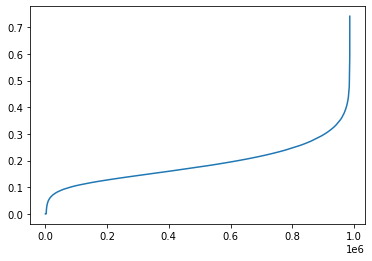

In [53]:
plt.plot(np.sort(preds_nuc['chr16']))

492
492


array([  8389,  52595,  64796,  70566,  76336, 103334, 135099, 150337,
       151833, 168539, 183447, 187133, 213360, 242595, 243055, 276937,
       292035, 313789, 316993, 317001, 352210, 455564, 482295, 495156,
       512140, 534284, 542643, 545279, 551875, 612187, 634205, 681371,
       689939, 696453, 701871, 712019, 715346, 785599, 804865, 867119,
       873390, 905148, 943608, 976589])

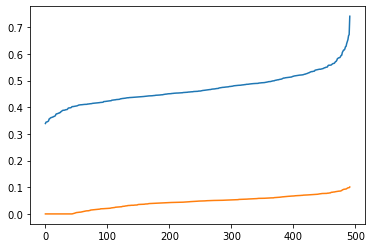

In [7]:
argmaxs = np.argmax(utils.chunk_regions(preds_nuc['chr16'][1000:-1000], 2000), axis=1)
argmaxs += np.arange(1000, len(argmaxs)*2000, 2000)
print(len(argmaxs))
plt.plot(np.sort(preds_nuc['chr16'][argmaxs]))

argmins = np.argmin(utils.chunk_regions(preds_nuc['chr16'][1000:-1000], 2000), axis=1)
argmins += np.arange(1000, len(argmins)*2000, 2000)
print(len(argmins))
plt.plot(np.sort(preds_nuc['chr16'][argmins]))
argmins[preds_nuc['chr16'][argmins] == 0]

In [8]:
one_hot = one_hots_yeast_ATCG['chr16'][argmaxs.reshape(-1, 1) + np.arange(-1000, 1001).reshape(1, -1)]
one_hot.shape

(492, 2001, 4)

In [9]:
part = 'max'
if part == 'min':
    indices = argmins
elif part == 'max':
    indices = argmaxs
else:
    raise ValueError('part must be either max or min')
model = tf.keras.models.load_model(Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'), custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
X = tf.Variable(one_hots_yeast_ATCG['chr16'][indices.reshape(-1, 1) + np.arange(-1000, 1001).reshape(1, -1)].reshape(-1, 2001, 1, 4), dtype=float)
with tf.GradientTape() as tape:
    Y = model(X, training=False)
grads = tape.gradient(Y, X)
del model
grads = np.array(grads).reshape(-1, 2001, 4)
grads_proj = grads + np.mean(grads, axis=2, keepdims=True)
X = np.array(X).astype(bool).reshape(grads.shape)
Y = np.array(Y).ravel()
Y.shape, grads.shape

2023-05-09 16:27:24.804995: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-05-09 16:27:24.855830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 16:27:24.855978: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-05-09 16:27:24.856025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 16:27:24.856142: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID

((492,), (492, 2001, 4))

In [10]:
np.savez(Path(data_dir, species, 'results', 'models_etienne', 'modisco', f'onehot_slide{part}chr16.npz'),
         np.transpose(X, [0, 2, 1]))

In [11]:
np.savez(Path(data_dir, species, 'results', 'models_etienne', 'modisco', f'saliency_nuc1_onseq_slide{part}chr16_test7.npz'),
         np.transpose((grads_proj * X), [0, 2, 1]))
np.savez(Path(data_dir, species, 'results', 'models_etienne', 'modisco', f'saliency_nuc1_sum_slide{part}chr16_test7.npz'),
         np.transpose(grads_proj.sum(axis=2, keepdims=True)*X, [0, 2, 1]))
np.savez(Path(data_dir, species, 'results', 'models_etienne', 'modisco', f'saliency_nuc1_slide{part}chr16_test7.npz'),
         np.transpose(grads_proj, [0, 2, 1]))

In [241]:
scores = np.load(Path(data_dir, species, 'results', 'models_etienne', 'DeepLIFT', f'score_nuc1_slide{part}chr16_vs_20dinucshuffle.npy'))
np.savez(Path(data_dir, species, 'results', 'models_etienne', 'modisco', f'DeepLIFTscore_nuc1_onseq_slide{part}chr16_test8.npz'),
         np.transpose((scores*X), [0, 2, 1]))
np.savez(Path(data_dir, species, 'results', 'models_etienne', 'modisco', f'DeepLIFTscore_nuc1_sum_slide{part}chr16_test8.npz'),
         np.transpose((scores.sum(axis=2, keepdims=True)*X), [0, 2, 1]))
np.savez(Path(data_dir, species, 'results', 'models_etienne', 'modisco', f'DeepLIFTscore_nuc1_slide{part}chr16_test8.npz'),
         np.transpose(scores, [0, 2, 1]))

<AxesSubplot:>

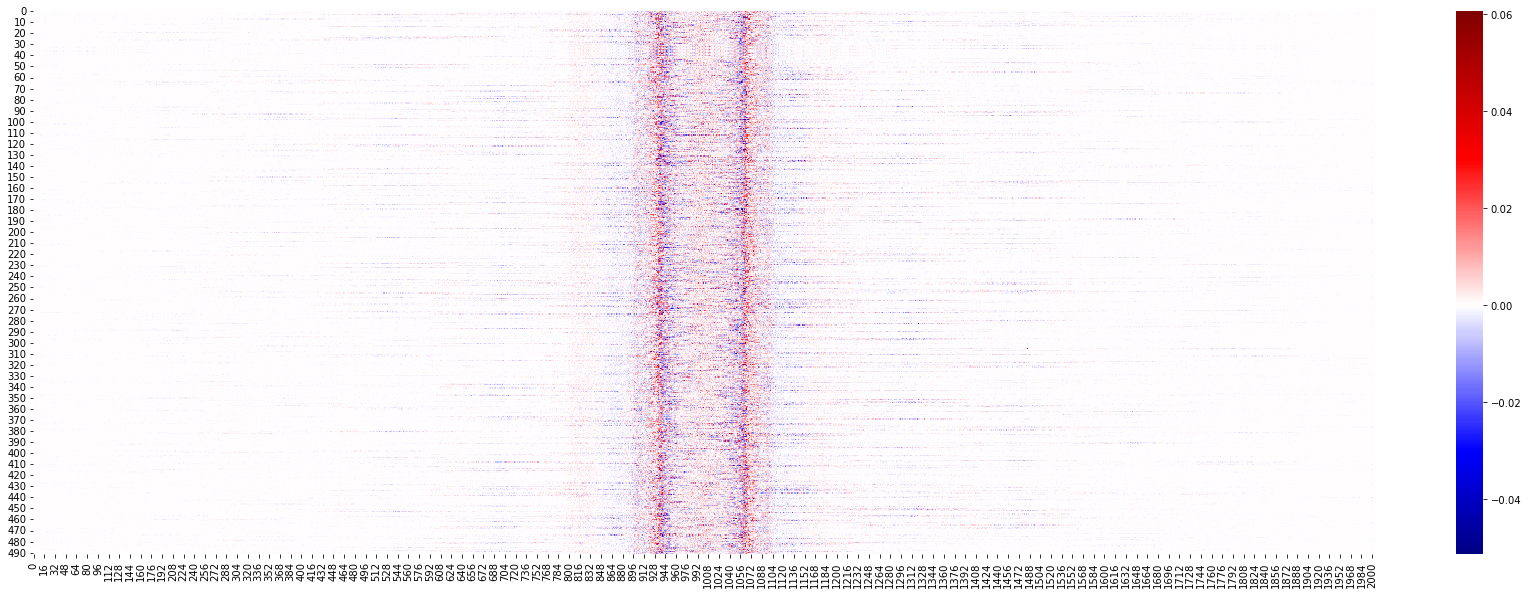

In [16]:
scores = np.load(Path(data_dir, species, 'results', 'models_etienne', 'DeepLIFT', 'score_nuc1_slidemaxchr16_vs_20dinucshuffle.npy'))
fig, ax = plt.subplots(1, 1, figsize=(30, 10), facecolor='w')
sns.heatmap((grads_proj*X).sum(axis=2), cmap='seismic', center=0, ax=ax)

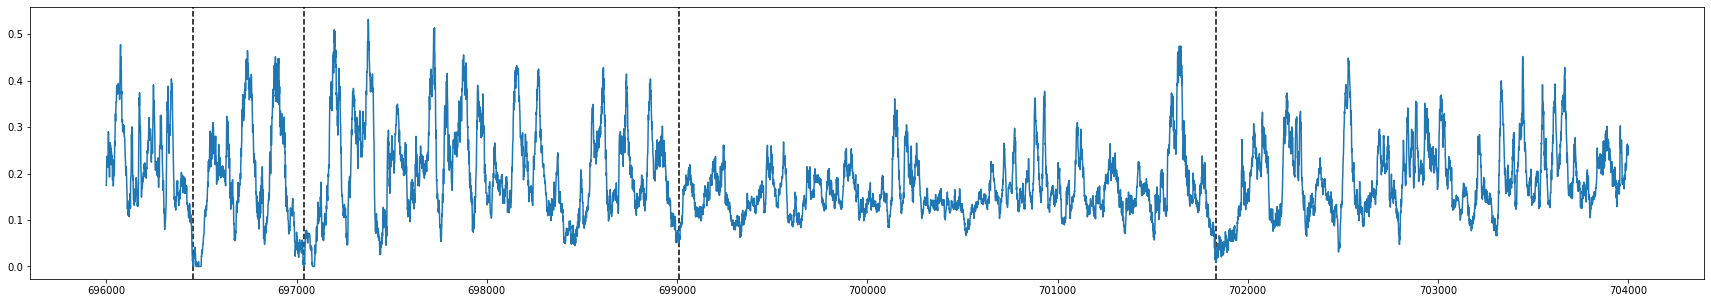

In [17]:
start = 8_000*87 # 114_050
stop = start + 8000 # + 2000 + 1001
plt.figure(figsize=(30, 5), facecolor='w')
m_start, m_stop = np.searchsorted(argmins, [start, stop])
for x in argmins[m_start:m_stop]:
    plt.axvline(x=x, color='k', linestyle='--')
plt.plot(np.arange(start, stop), preds_nuc['chr16'][start:stop])


In [12]:
from typing import Iterable
from numbers import Number
def consecutive(data: Iterable[Number], stepsize: int = 1) -> np.array:
    return np.split(data, np.where(np.diff(data) > stepsize)[0]+1)

DeepLIFT scores

In [23]:
seq_start = 114_050
n_seqs = 1000
one_hot = one_hots_yeast_ATCG['chr16'][seq_start:seq_start+2000+n_seqs]
preds = preds_nuc['chr16'][seq_start:seq_start+2000+n_seqs]
X = utils.sliding_window_view(one_hots_yeast_ATCG['chr16'][seq_start:seq_start+2000+n_seqs], (2001, 4)).reshape(-1, 2001, 4)
Y = preds[1000:1000+n_seqs]

# scores = np.load(Path(data_dir, species, 'results', 'models_etienne', 'DeepLIFT', 'score_nuc1_115050-116050.npy'))
# scores = np.load(Path(data_dir, species, 'results', 'models_etienne', 'DeepLIFT', 'score_nuc1_115050-116050_vs_GC0.38.npy'))
# scores = np.load(Path(data_dir, species, 'results', 'models_etienne', 'DeepLIFT', 'score_nuc1_115050-116050_vs_20nucshuffle.npy'))
scores = np.load(Path(data_dir, species, 'results', 'models_etienne', 'DeepLIFT', 'score_nuc1_115050-116050_vs_20dinucshuffle.npy'))
# scores = np.load(Path(data_dir, species, 'results', 'models_etienne', 'DeepLIFT', 'score_nuc1_115050-116050_RevealCancel.npy'))
# scores = np.load(Path(data_dir, species, 'results', 'models_etienne', 'DeepLIFT', 'score_nuc1_115050-116050_RevealCancel_vs_GC0.38.npy'))
# scores = np.load(Path(data_dir, species, 'results', 'models_etienne', 'DeepLIFT', 'score_nuc1_115050-116050_RevealCancel_vs_20nucshuffle.npy'))
# scores = np.load(Path(data_dir, species, 'results', 'models_etienne', 'DeepLIFT', 'score_nuc1_115050-116050_RevealCancel_vs_20dinucshuffle.npy'))
print(scores.shape)

(1000, 2001, 4)


1000 433 349


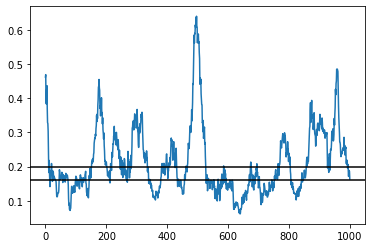

In [24]:
print(len(Y), np.sum(Y >= 0.2), np.sum(Y <= 0.16))
plt.plot(Y)
plt.axhline(y=0.2, color='k')
plt.axhline(y=0.16, color='k')

In [30]:
high = Y > 0.20
low = Y <= 0.16
mid = ~(high | low)
print(high.sum(), mid.sum(), low.sum())
masks = {'high': high, 'mid': mid, 'low': low}

451 176 373


In [31]:
# Save for modisco
scores = np.load(Path(data_dir, species, 'results', 'models_etienne', 'DeepLIFT', 'score_nuc1_115050-116050_vs_20dinucshuffle.npy'))
for part, mask in masks.items():
    np.savez(Path(data_dir, species, 'results', 'models_etienne', 'modisco', f'DeepLIFTscore_114050-117050_{part}_test5.npz'),
             np.transpose((scores.sum(axis=2, keepdims=True)*X[:1000])[mask], [0, 2, 1]))
    np.savez(Path(data_dir, species, 'results', 'models_etienne', 'modisco', f'DeepLIFTscore_114050-117050_{part}_test6.npz'),
             np.transpose(scores[mask], [0, 2, 1]))

In [35]:
part = 'max'
scores = np.load(Path(data_dir, species, 'results', 'models_etienne', 'DeepLIFT', f'score_nuc1_slide{part}chr16_vs_20dinucshuffle.npy'))
n_seqs = 492

NameError: name 'scores' is not defined

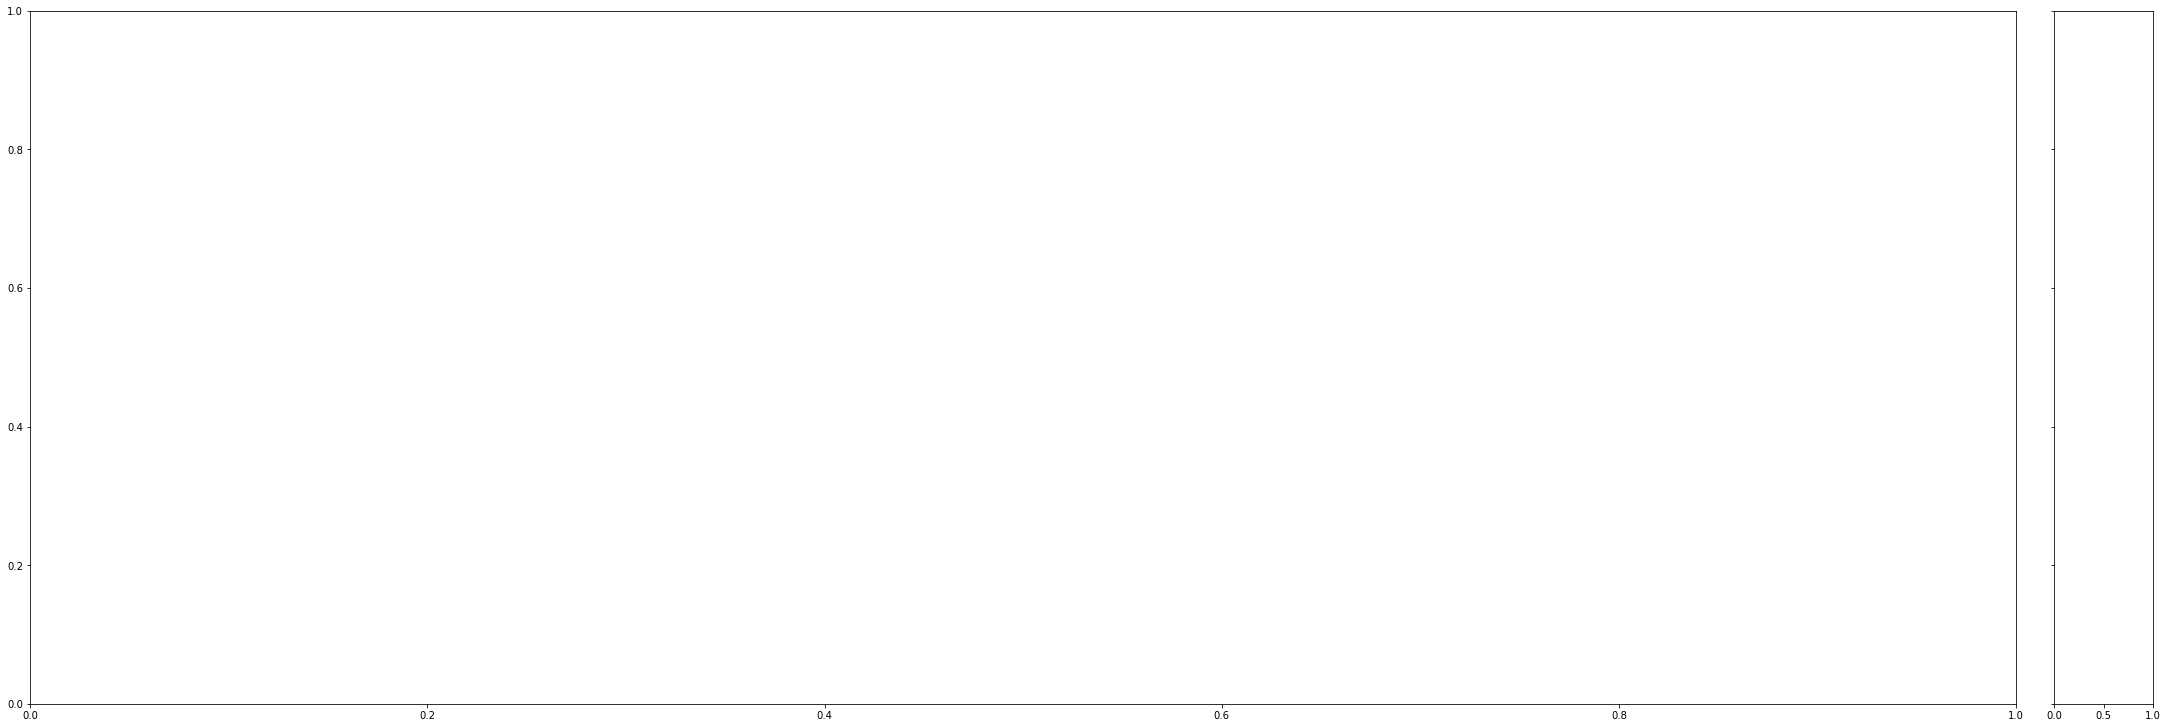

In [13]:
plot_start = 0
plot_stop = 2001
fig, axes = plt.subplots(1, 2, figsize=(30, 10), sharey='row', layout='constrained', facecolor='w',
                         gridspec_kw={'width_ratios': [20, 1]})
sns.heatmap(scores.sum(axis=0)[plot_start:plot_stop, [0, 2, 3, 1]].T, cmap='seismic', center=0, ax=axes[0],# cbar_ax=axes[0, 1],
            xticklabels=100, yticklabels=list('ACGT'))
# axes[1].plot(Y, np.arange(len(Y)), color='k', label='predictions')
plt.show()
plt.close()

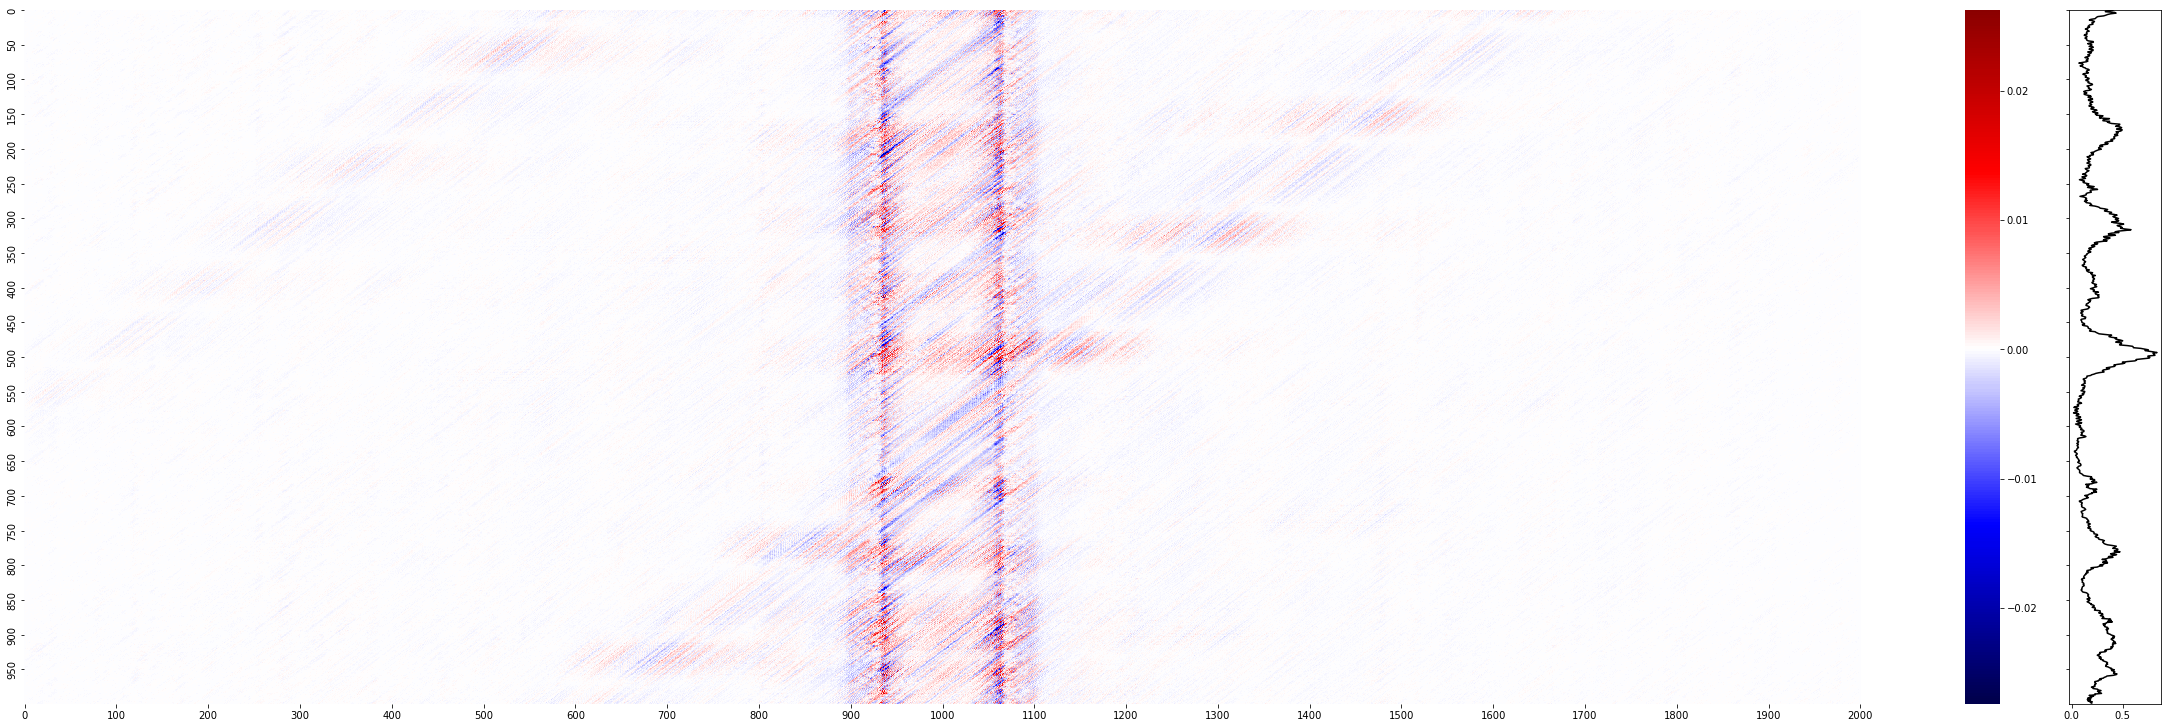

In [62]:
plot_start = 0
plot_stop = 2001
fig, axes = plt.subplots(1, 2, figsize=(30, 10), sharey='row', layout='constrained', facecolor='w',
                         gridspec_kw={'width_ratios': [20, 1]})
sns.heatmap(scores.sum(axis=-1)[:, plot_start:plot_stop], cmap='seismic', center=0, ax=axes[0],# cbar_ax=axes[0, 1],
            xticklabels=100, yticklabels=50)
axes[1].plot(Y, np.arange(n_seqs), color='k', label='predictions')
plt.show()
plt.close()

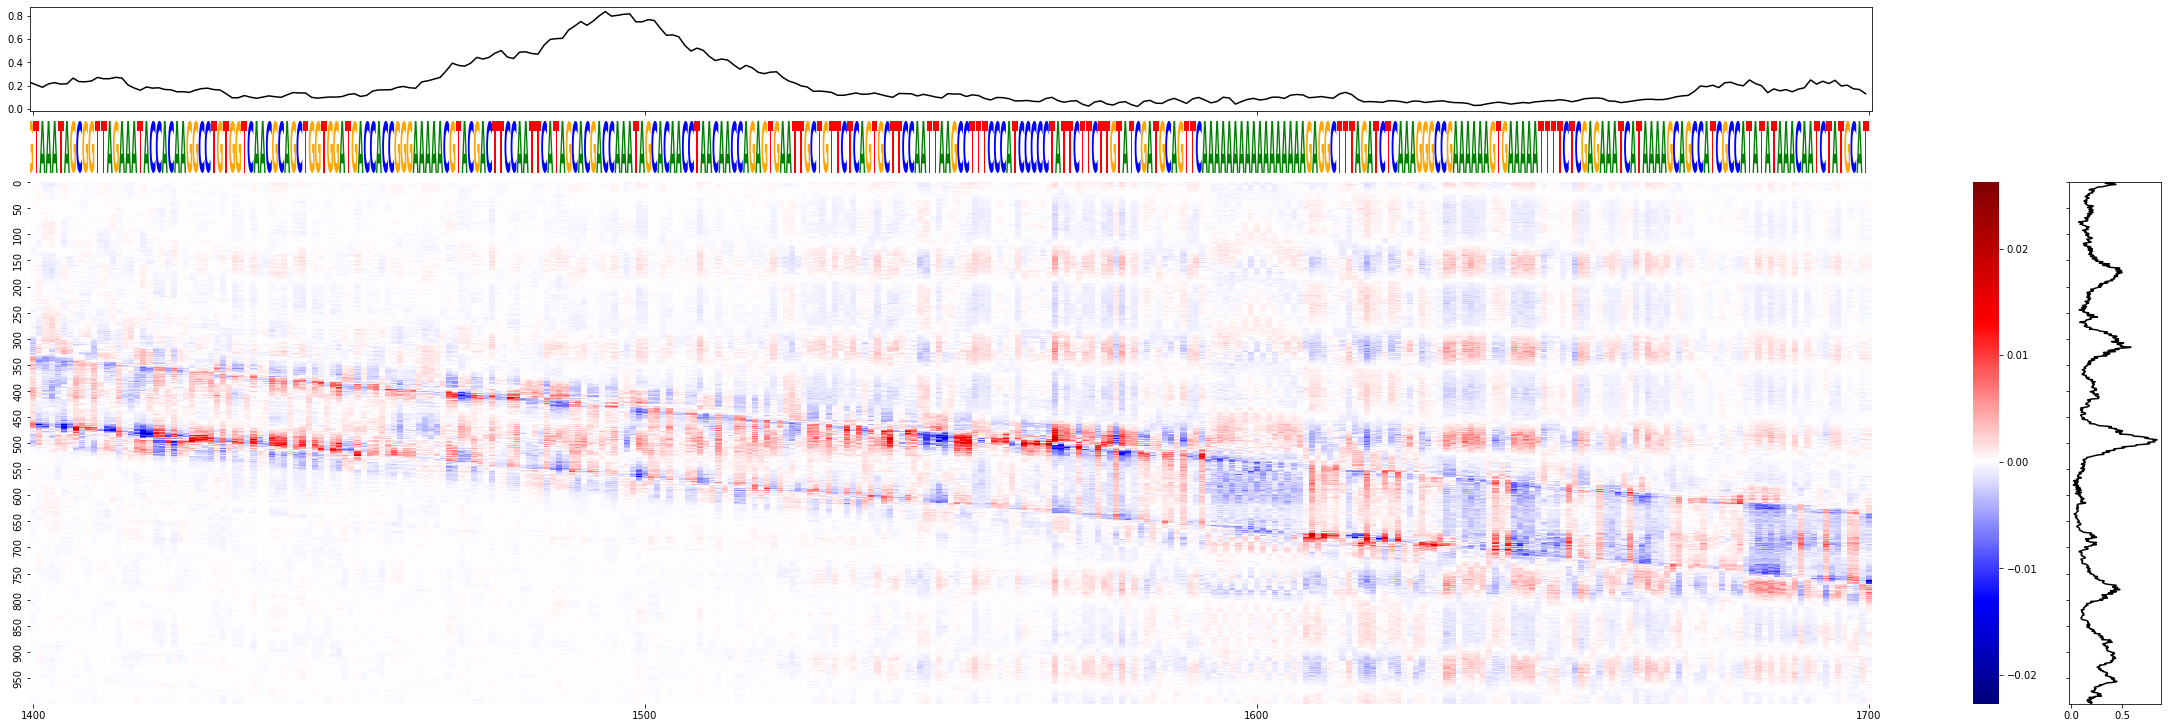

In [146]:
mid_idx = n_seqs // 2
imps_seq = scores
aligned_imps_seq = pd.DataFrame(
    0.,
    index = np.arange(n_seqs),
    columns = np.arange(2000+n_seqs))
for i in range(len(imps_seq)):
    aligned_imps_seq.iloc[i, i:2001+i] = imps_seq[i]

plot_start = mid_idx + 900
plot_stop = mid_idx + 1201
fig, axes = plt.subplots(3, 2, figsize=(30, 10), sharex='col', sharey='row', layout='constrained',
                         gridspec_kw={'width_ratios': [20, 1],
                                      'height_ratios': [2, 1, 10]})
fig.set_facecolor('w')
axes[0, 0].plot(preds[plot_start:plot_stop], color='k', label='predictions')
lm.Logo(pd.DataFrame(one_hot[plot_start:plot_stop], columns=list('ATCG')), ax=axes[1, 0])
axes[1, 0].set_axis_off()
sns.heatmap(aligned_imps_seq.loc[:, plot_start:plot_stop-1], cmap='seismic', center=0, ax=axes[2, 0],# cbar_ax=axes[0, 1],
            xticklabels=100, yticklabels=50)
axes[2, 1].plot(Y, np.arange(n_seqs), color='k', label='predictions')
axes[0, 1].remove()
axes[1, 1].remove()
plt.show()
plt.close()

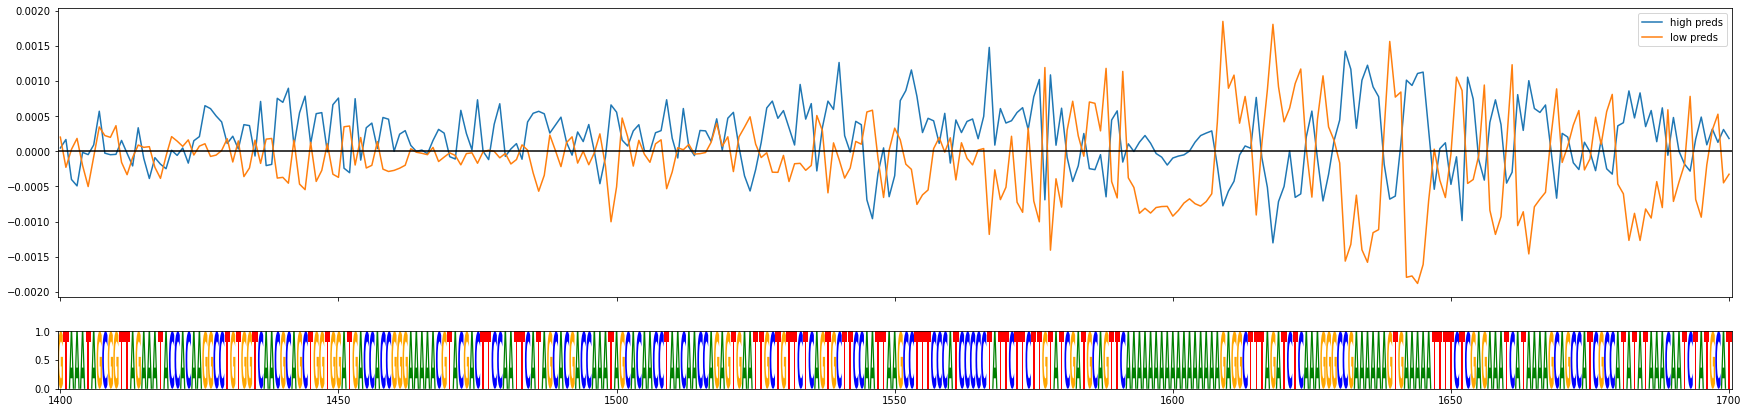

In [147]:
plot_start = mid_idx + 900
plot_stop = mid_idx + 1201
fig, axes = plt.subplots(2, 1, figsize=(30, 7), sharex='col', facecolor='w',
                         gridspec_kw={'height_ratios': [5, 1]})
aligned_imps_seq[high].mean(axis=0).loc[plot_start:plot_stop-1].plot(ax=axes[0], label='high preds')
aligned_imps_seq[low].mean(axis=0).loc[plot_start:plot_stop-1].plot(ax=axes[0], label='low preds')
axes[0].axhline(y=0, color='k')
axes[0].legend()
lm.Logo(pd.DataFrame(one_hot, columns=list('ATCG')).loc[plot_start:plot_stop-1], ax=axes[1])

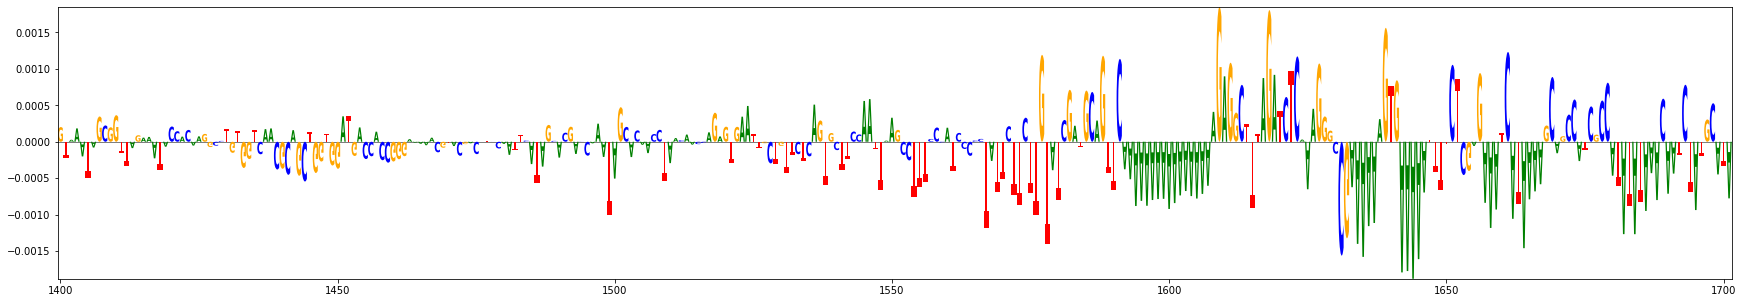

In [150]:
plot_start = mid_idx + 900
plot_stop = mid_idx + 1201
df_high_preds = pd.DataFrame(one_hot, columns=list('ATCG')).multiply(
    aligned_imps_seq[low].mean(axis=0),
    axis=0)
fig, ax = plt.subplots(1, 1, figsize=(30, 5), facecolor='w')
lm.Logo(df_high_preds.loc[plot_start:plot_stop], ax=ax)

Saliency

In [26]:
seq_start = 114_050 # 100_000 #
n_seqs = 1000
model = tf.keras.models.load_model(Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'), custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
one_hot = one_hots_yeast_ATCG['chr16'][seq_start:seq_start+2000+n_seqs]
preds = preds_nuc['chr16'][seq_start:seq_start+2000+n_seqs]
X = tf.Variable(utils.sliding_window_view(one_hot, (2001, 4)).reshape(-1, 2001, 1, 4), dtype=float)
with tf.GradientTape() as tape:
    Y = model(X, training=False)
grads = tape.gradient(Y, X)
del model
grads = np.array(grads).reshape(-1, 2001, 4)
grads_proj = grads + np.mean(grads, axis=2, keepdims=True)
X = np.array(X).astype(bool).reshape(grads.shape)
Y = np.array(Y).ravel()
Y.shape, grads.shape

((1000,), (1000, 2001, 4))

In [73]:
rand_indices = np.random.choice(np.arange(1000, len(one_hots_yeast['chr16'])-1000), 10000, replace=False)
rand_indices_coh = np.random.choice(np.arange(len(one_hots_yeast['chr16'])-32768), 100, replace=False)

In [83]:
rand_indices_coh

array([  5195,   5419,  24063,  34286,  52551,  78684,  86093,  90524,
       111993, 132979, 148613, 161016, 163410, 175566, 178242, 183869,
       189868, 198839, 211573, 231257, 234483, 238694, 248228, 248873,
       249217, 261859, 269716, 275108, 297148, 300594, 302787, 314945,
       319834, 327238, 328800, 365481, 374623, 374715, 380943, 384216,
       392259, 393677, 399279, 429119, 452931, 457011, 484853, 488027,
       488924, 492353, 497783, 499720, 520065, 523278, 523881, 527073,
       548592, 550334, 564828, 565356, 568699, 571552, 575289, 590204,
       594892, 598745, 602507, 604374, 620693, 631716, 637211, 650060,
       651430, 662730, 667342, 667974, 681566, 693517, 697946, 707797,
       729300, 739158, 766378, 772890, 781361, 783847, 802852, 808579,
       811605, 841928, 857657, 889584, 889609, 891640, 900584, 918589,
       930317, 940876, 944215, 952092])

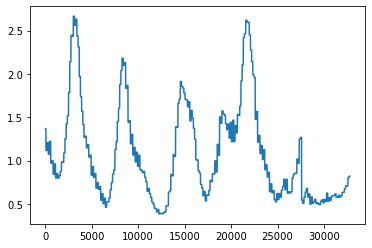

In [84]:
plt.plot(preds_coh['chr16'][rand_indices_coh[0]:rand_indices_coh[0]+32768])

In [74]:
indices = rand_indices_coh # argmaxs # argmins #

In [94]:
def get_gradients(model, one_hots, batch_size=1024):
    grads = np.empty(one_hots.shape)
    preds = np.empty(len(one_hots))
    n_batches = int(np.ceil((len(one_hots) / batch_size)))
    for i in range(n_batches):
        batch_start, batch_stop = i*batch_size, (i+1)*batch_size
        X = tf.Variable(one_hots[batch_start:batch_stop], dtype=float)
        with tf.GradientTape() as tape:
            Y = model(X, training=False)
        grads[batch_start:batch_stop] = np.array(tape.gradient(Y, X))
        preds[batch_start:batch_stop] = np.array(Y).squeeze()
    return grads.squeeze(), preds

In [95]:
model = tf.keras.models.load_model(Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'), custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
X = one_hots_yeast_ATCG['chr16'][indices.reshape(-1, 1) + np.arange(-1000, 1001).reshape(1, -1)].reshape(-1, 2001, 1, 4)
grads, Y = get_gradients(model, X)
del model
X = X.reshape(grads.shape)
grads_proj = grads + np.mean(grads, axis=2, keepdims=True)
# Y = Y.ravel()
Y.shape, grads.shape

((100,), (100, 2001, 4))

In [111]:
model = tf.keras.models.load_model(Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'), custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
X = tf.Variable(one_hots_yeast['chr16'][indices.reshape(-1, 1) + np.arange(32768).reshape(1, -1)].reshape(-1, 32768, 4), dtype=float)
with tf.GradientTape() as tape:
    Y = model(X, training=False)[:, 127]
grads = tape.gradient(Y, X)
del model
grads = np.array(grads)
grads_proj = grads + np.mean(grads, axis=2, keepdims=True)
X = np.array(X).astype(bool).reshape(grads.shape)
Y = np.array(Y).squeeze()
Y.shape, grads.shape

((100,), (100, 32768, 4))

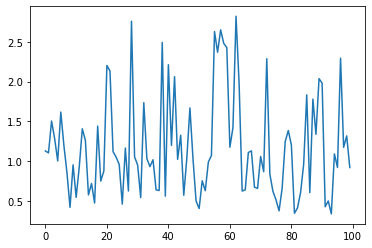

In [113]:
plt.plot(Y)

In [114]:
Yorder = np.argsort(Y)
sortedX, sortedY, sortedgrads, sortedgrads_proj = X[Yorder], Y[Yorder], grads[Yorder], grads_proj[Yorder]

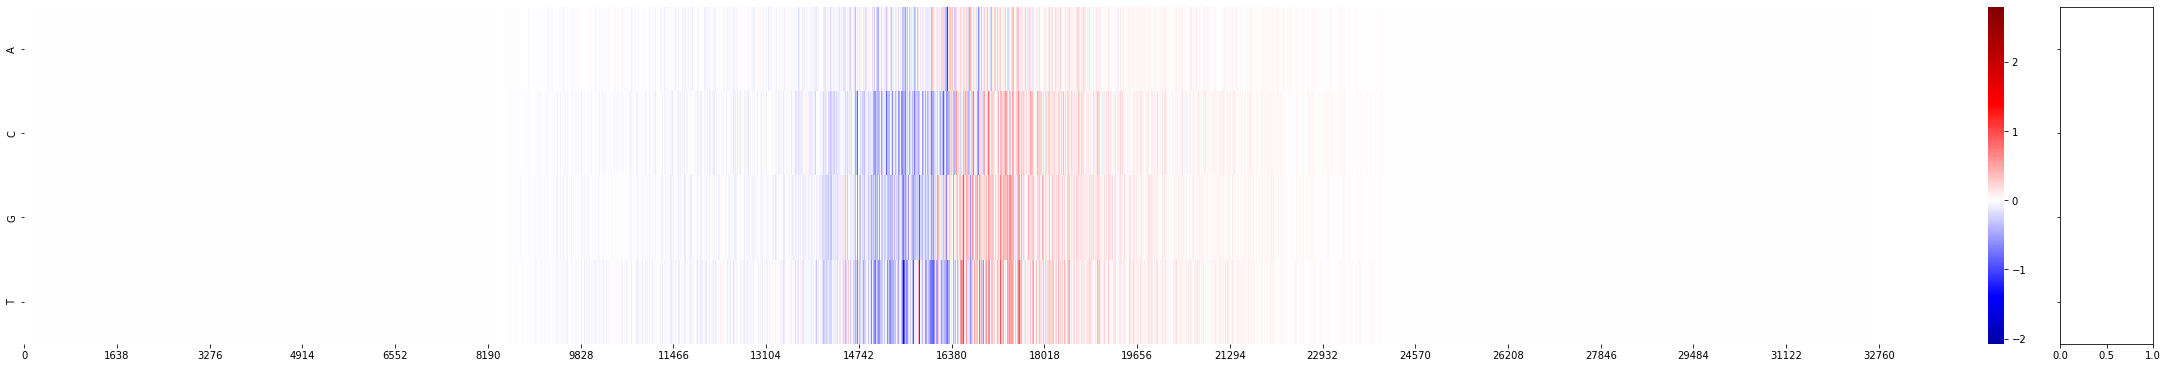

In [116]:
plot_start = 0
plot_stop = 32768
fig, axes = plt.subplots(1, 2, figsize=(30, 5), sharey='row', layout='constrained', facecolor='w',
                         gridspec_kw={'width_ratios': [20, 1]})
sns.heatmap(grads_proj.sum(axis=0)[plot_start:plot_stop, [0, 2, 3, 1]].T, cmap='seismic', center=0, ax=axes[0],# cbar_ax=axes[0, 1],
            xticklabels=(plot_stop - plot_start) // 20, yticklabels=list('ACGT'))
# axes[1].plot(Y, np.arange(len(Y)), color='k', label='predictions')
plt.show()
plt.close()

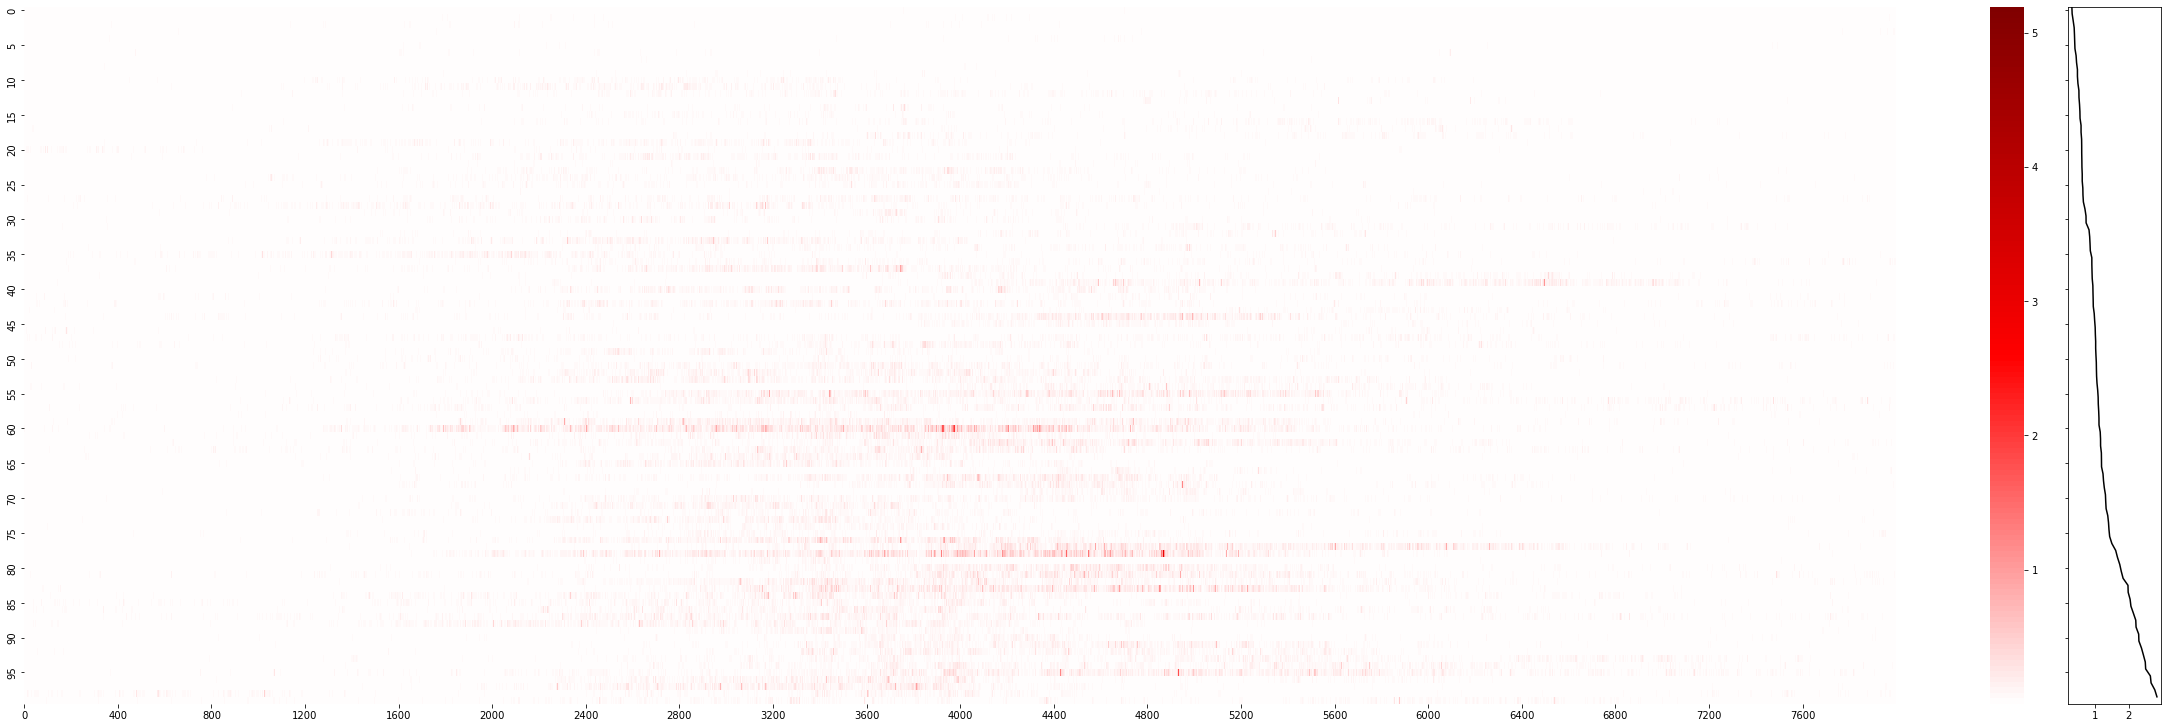

In [121]:
plot_start = 16384 - 4000
plot_stop = 16384 + 4000
fig, axes = plt.subplots(1, 2, figsize=(30, 10), sharey='row', layout='constrained', facecolor='w',
                         gridspec_kw={'width_ratios': [20, 1]})
sns.heatmap(np.abs(sortedgrads_proj).sum(axis=-1)[:, plot_start:plot_stop], cmap='seismic', center=0, ax=axes[0],# cbar_ax=axes[0, 1],
            xticklabels=(plot_stop - plot_start) // 20, yticklabels=len(Y) // 20)
axes[1].plot(sortedY, np.arange(len(Y)), color='k', label='predictions')
plt.show()
plt.close()

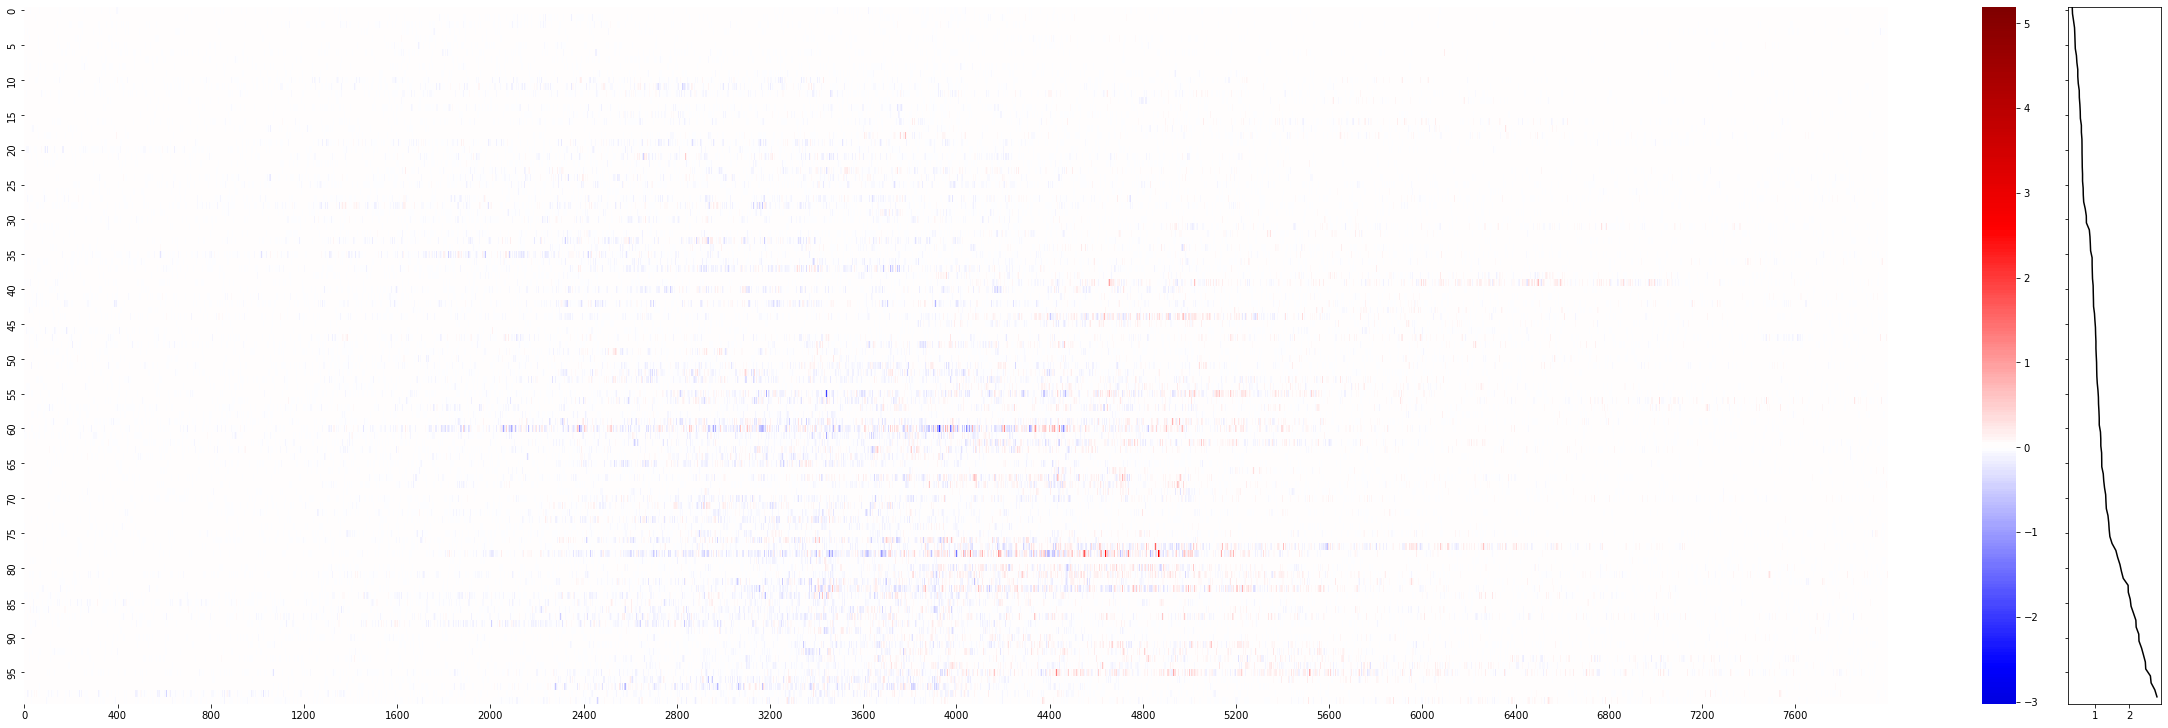

In [120]:
plot_start = 16384 - 4000
plot_stop = 16384 + 4000
fig, axes = plt.subplots(1, 2, figsize=(30, 10), sharey='row', layout='constrained', facecolor='w',
                         gridspec_kw={'width_ratios': [20, 1]})
sns.heatmap(sortedgrads_proj.sum(axis=-1)[:, plot_start:plot_stop], cmap='seismic', center=0, ax=axes[0],# cbar_ax=axes[0, 1],
            xticklabels=(plot_stop - plot_start) // 20, yticklabels=len(Y) // 20)
axes[1].plot(sortedY, np.arange(len(Y)), color='k', label='predictions')
plt.show()
plt.close()

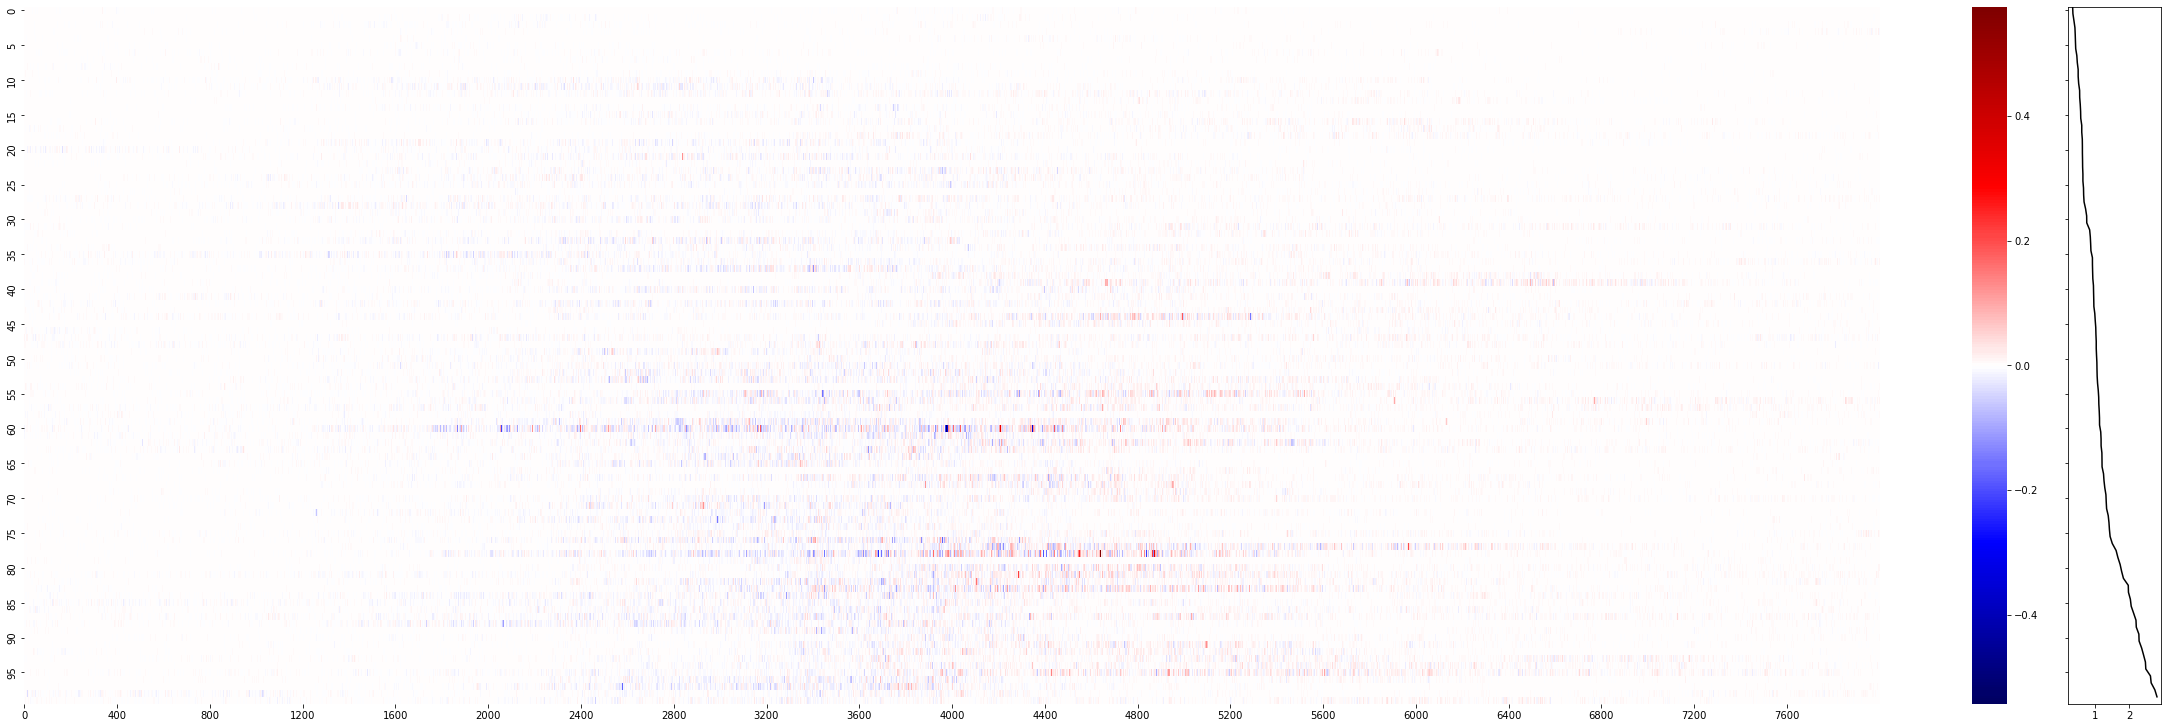

In [122]:
sortedgrads_proj_seq = (sortedgrads_proj*sortedX).sum(axis=-1)
plot_start = 16384 - 4000 # 800
plot_stop = 16384 + 4000 # 1201
fig, axes = plt.subplots(1, 2, figsize=(30, 10), sharey='row', layout='constrained', facecolor='w',
                         gridspec_kw={'width_ratios': [20, 1]})
sns.heatmap(sortedgrads_proj_seq[:, plot_start:plot_stop], cmap='seismic', center=0, ax=axes[0],# cbar_ax=axes[0, 1],
            xticklabels=(plot_stop - plot_start) // 20, yticklabels=len(Y) // 20)
axes[1].plot(sortedY, np.arange(len(Y)), color='k', label='predictions')
plt.show()
plt.close()

In [30]:
high = Y > 0.20
low = Y <= 0.16
mid = ~(high | low)
print(high.sum(), mid.sum(), low.sum())
masks = {'high': high, 'mid': mid, 'low': low}

433 218 349


In [39]:
# Save for modisco
for part, mask in masks.items():
    np.savez(Path(data_dir, species, 'results', 'models_etienne', 'modisco', f'saliency_onseq_114050-117050_{part}_test4.npz'),
             np.transpose((grads_proj * X)[mask], [0, 2, 1]))
    np.savez(Path(data_dir, species, 'results', 'models_etienne', 'modisco', f'onehot_114050-117050_{part}.npz'),
             np.transpose(X[mask], [0, 2, 1]))

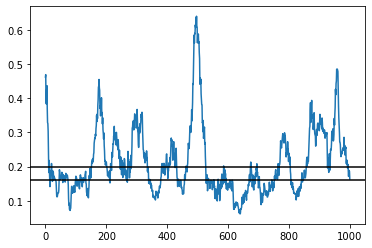

In [42]:
plt.plot(Y)
plt.axhline(y=0.2, color='k')
plt.axhline(y=0.16, color='k')

In [32]:
mid_idx = len(Y) // 2
grad = grads[mid_idx]
# True one_hot sequence
df_seq = pd.DataFrame(X[mid_idx],
                      index=np.arange(mid_idx, mid_idx+2001),
                      columns=list('ATCG'))

# Gradient
df_grad = pd.DataFrame(grad,
                       index=np.arange(mid_idx, mid_idx+2001),
                       columns=list('ATCG'))
# Gradient on true sequence
df_grad_seq = df_grad.copy()
df_grad_seq[df_seq != 1] = 0

# Projected gradient
grad_proj = grads_proj[mid_idx]
df_grad_proj = pd.DataFrame(grad_proj,
                            index=np.arange(mid_idx, mid_idx+2001),
                            columns=list('ATCG'))
# Projected gradient on true sequence
df_grad_proj_seq = df_grad_proj.copy()
df_grad_proj_seq[df_seq != 1] = 0
# Projected gradient on other nucleotides
df_grad_proj_noseq = df_grad_proj.copy()
df_grad_proj_noseq[df_seq == 1] = 0

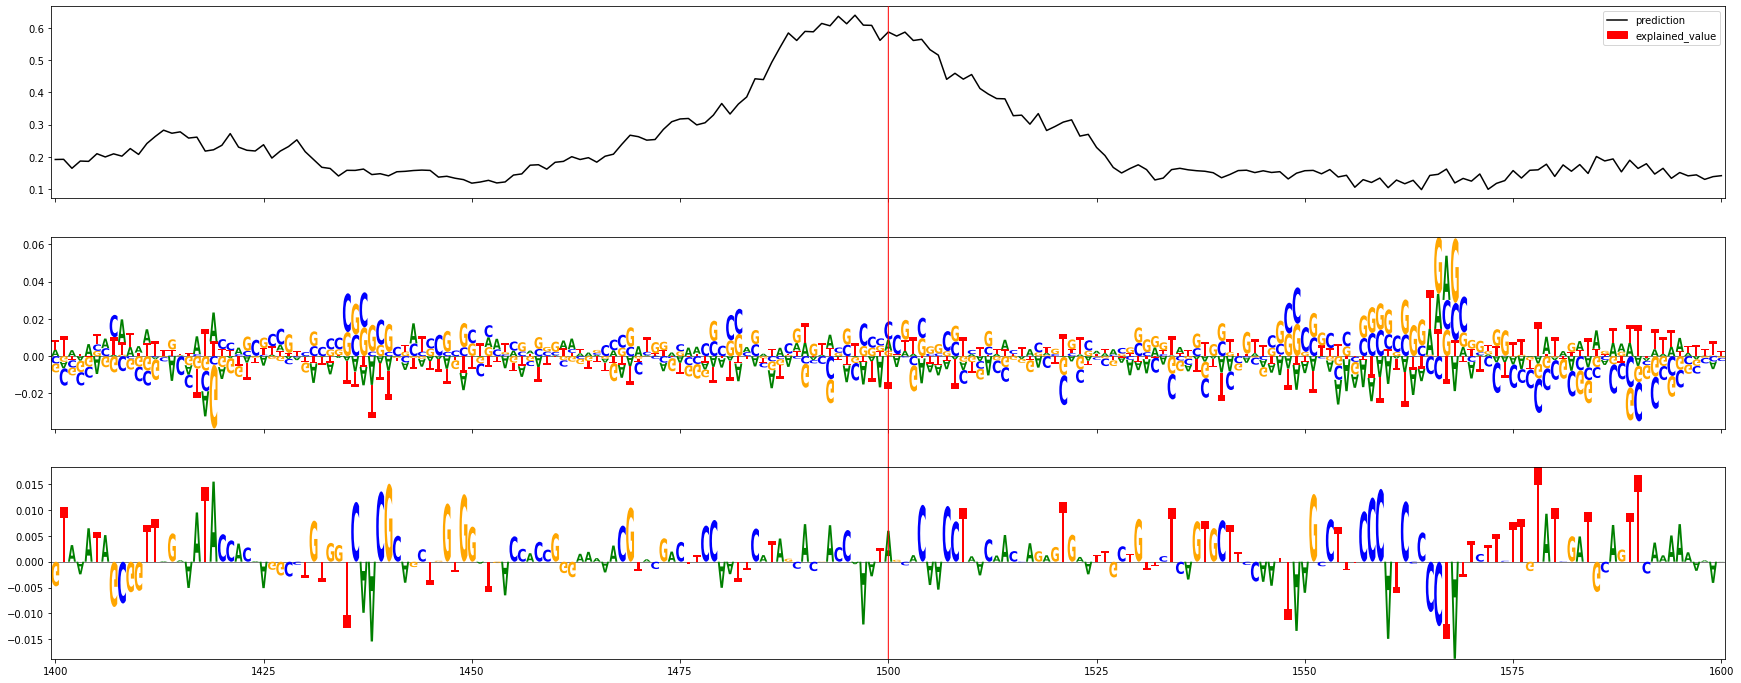

In [33]:
plot_start = mid_idx + 900
plot_stop = mid_idx + 1101
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(30, 12))
fig.set_facecolor('w')
axes[0].plot(np.arange(plot_start, plot_stop), preds[plot_start:plot_stop], color='k', label='prediction')
lm.Logo(df_grad.loc[plot_start:plot_stop-1], ax=axes[1])
lm.Logo(df_grad_seq.loc[plot_start:plot_stop-1], ax=axes[2])
con = ConnectionPatch(xyA=(mid_idx + 1000, axes[2].get_ylim()[0]), xyB=(mid_idx + 1000, axes[0].get_ylim()[1]), coordsA='data', coordsB='data', axesA=axes[2], axesB=axes[0], color='r', label='explained_value')
axes[2].add_artist(con)
# Get handles and labels of all axes
handles, labels = (sum(l, start=[]) for l in zip(*[ax.get_legend_handles_labels() for ax in axes]))
axes[0].legend(handles, labels)
plt.show()
plt.close()

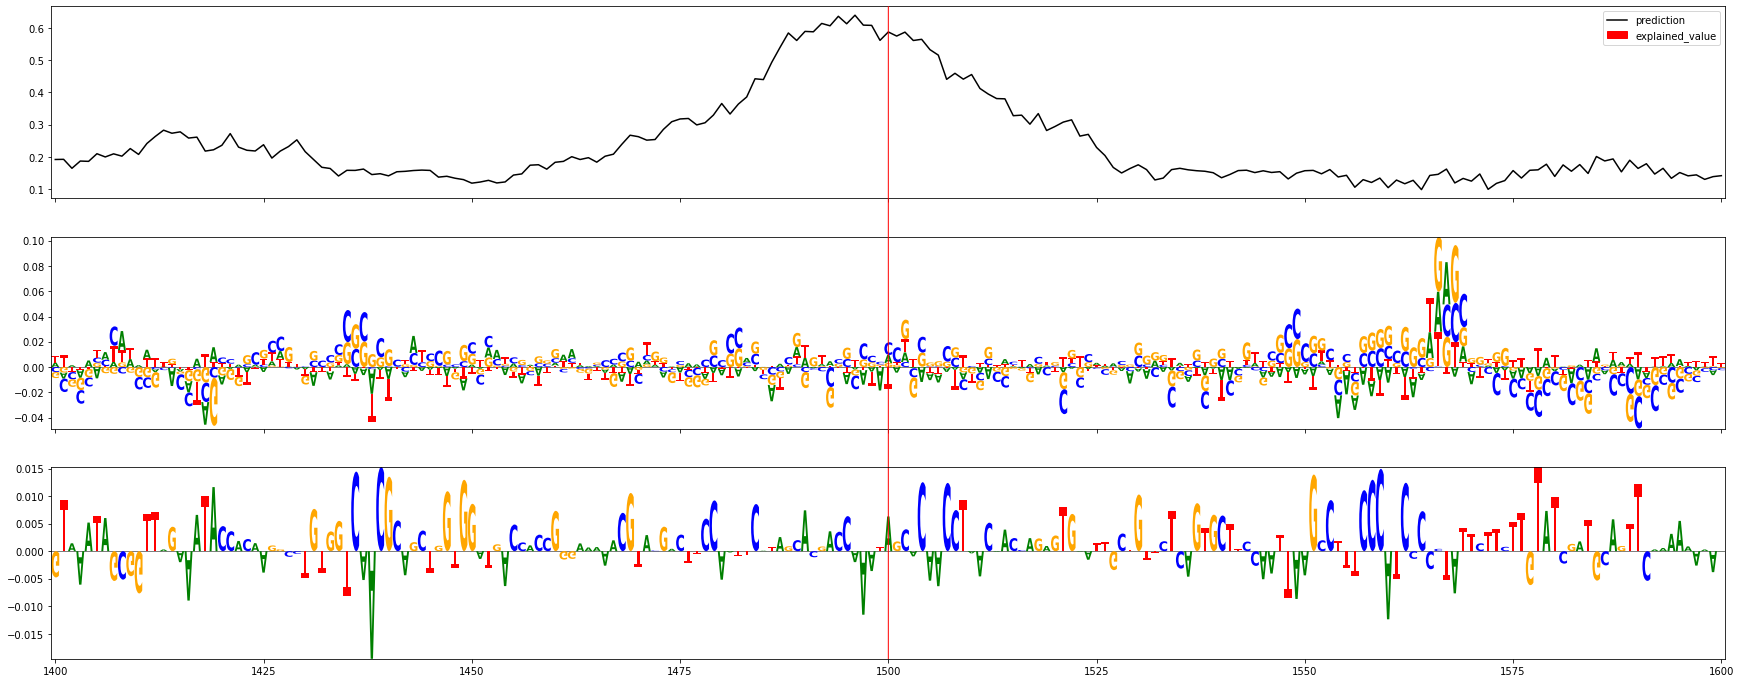

In [34]:
plot_start = mid_idx + 900
plot_stop = mid_idx + 1101
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(30, 12))
fig.set_facecolor('w')
axes[0].plot(np.arange(plot_start, plot_stop), preds[plot_start:plot_stop], color='k', label='prediction')
lm.Logo(df_grad_proj.loc[plot_start:plot_stop-1], ax=axes[1])
lm.Logo(df_grad_proj_seq.loc[plot_start:plot_stop-1], ax=axes[2])
con = ConnectionPatch(xyA=(mid_idx + 1000, axes[2].get_ylim()[0]), xyB=(mid_idx + 1000, axes[0].get_ylim()[1]), coordsA='data', coordsB='data', axesA=axes[2], axesB=axes[0], color='r', label='explained_value')
axes[2].add_artist(con)
# Get handles and labels of all axes
handles, labels = (sum(l, start=[]) for l in zip(*[ax.get_legend_handles_labels() for ax in axes]))
leg = axes[0].legend(handles, labels)
plt.show()
plt.close()

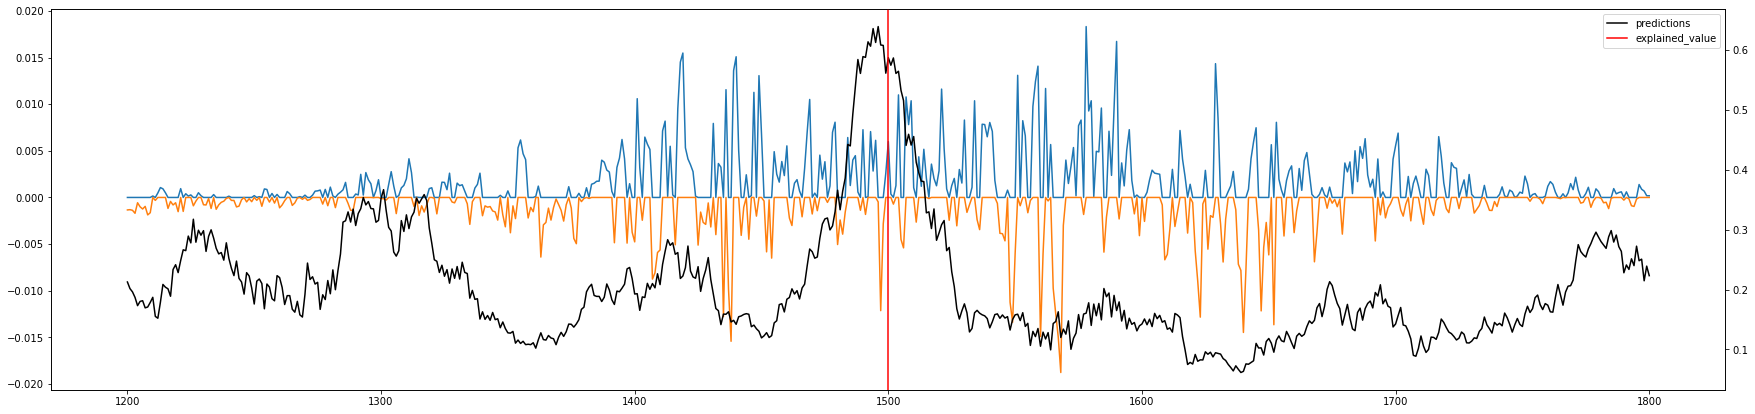

In [35]:
plot_start = mid_idx + 700
plot_stop = mid_idx + 1301
plt.figure(figsize=(30, 7), facecolor='w')
ax = plt.subplot(111)
df_grad_seq[df_grad > 0].sum(axis=1).loc[plot_start:plot_stop-1].plot(ax=ax)
df_grad_seq[df_grad <= 0].sum(axis=1).loc[plot_start:plot_stop-1].plot(ax=ax)
ax2 = ax.twinx()
ax2.plot(np.arange(plot_start, plot_stop), preds[plot_start:plot_stop], color='k', label='predictions')
ax2.axvline(x=mid_idx + 1000, label='explained_value', color='r')
ax2.legend()
plt.show()
plt.close()

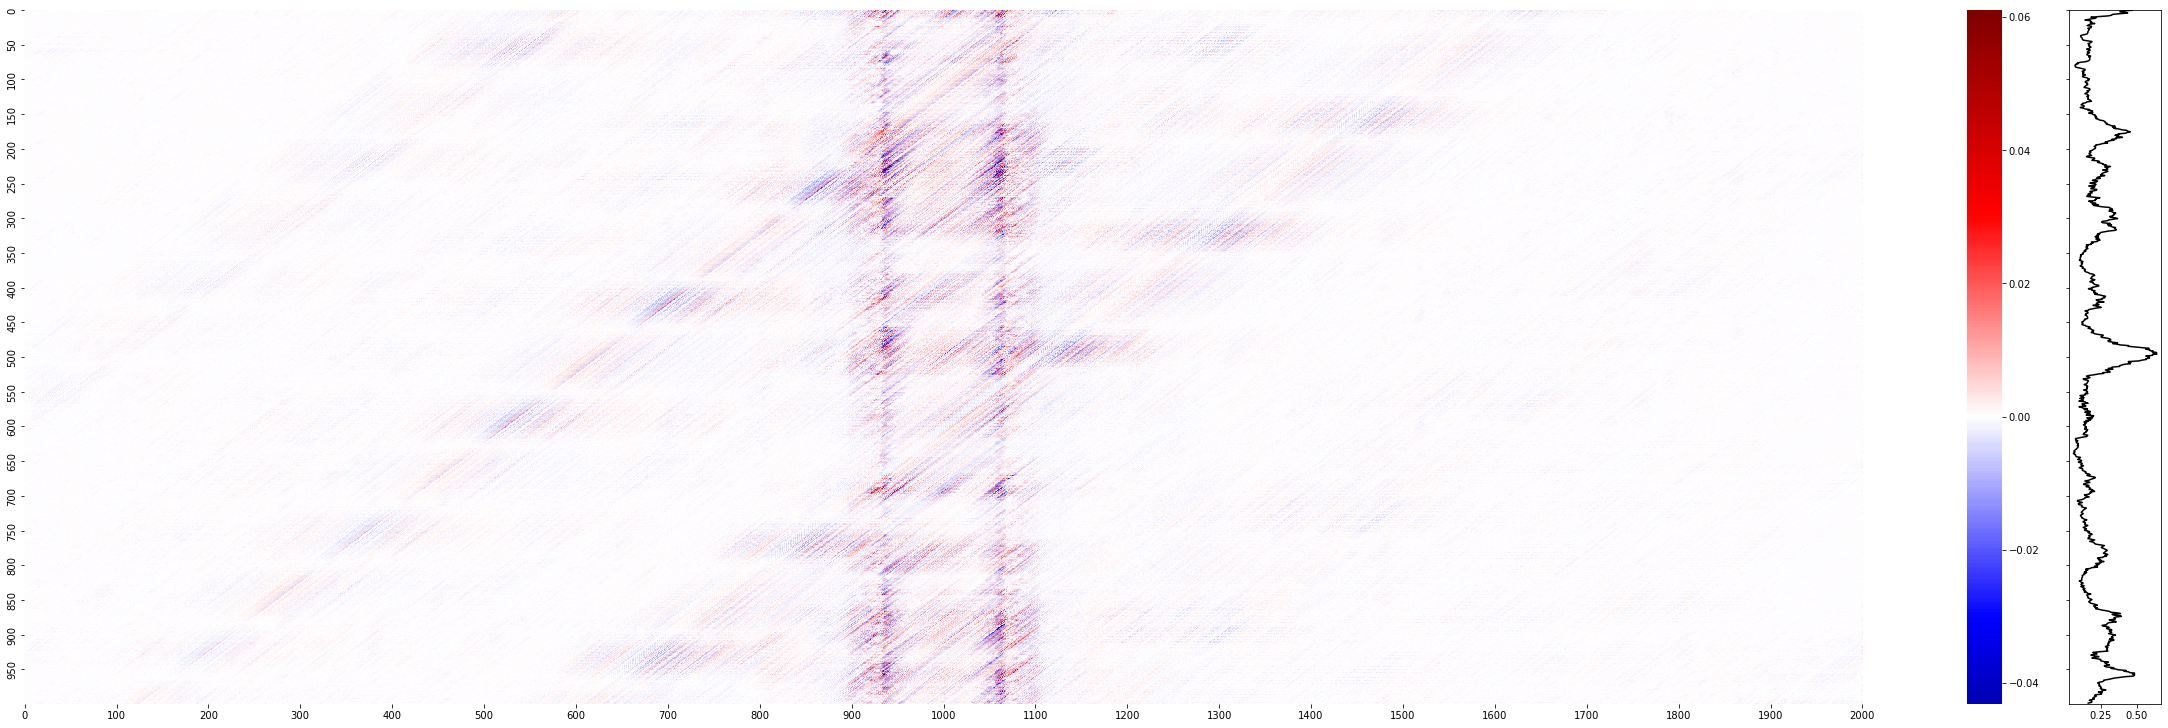

In [36]:
grads_seq = grads_proj[X].reshape(-1, 2001)
plot_start = 0
plot_stop = 2001
fig, axes = plt.subplots(1, 2, figsize=(30, 10), sharey='row', layout='constrained', facecolor='w',
                         gridspec_kw={'width_ratios': [20, 1]})
sns.heatmap(grads_seq[:, plot_start:plot_stop], cmap='seismic', center=0, ax=axes[0],# cbar_ax=axes[0, 1],
            xticklabels=100, yticklabels=50)
axes[1].plot(Y, np.arange(len(Y)), color='k', label='predictions')
plt.show()
plt.close()

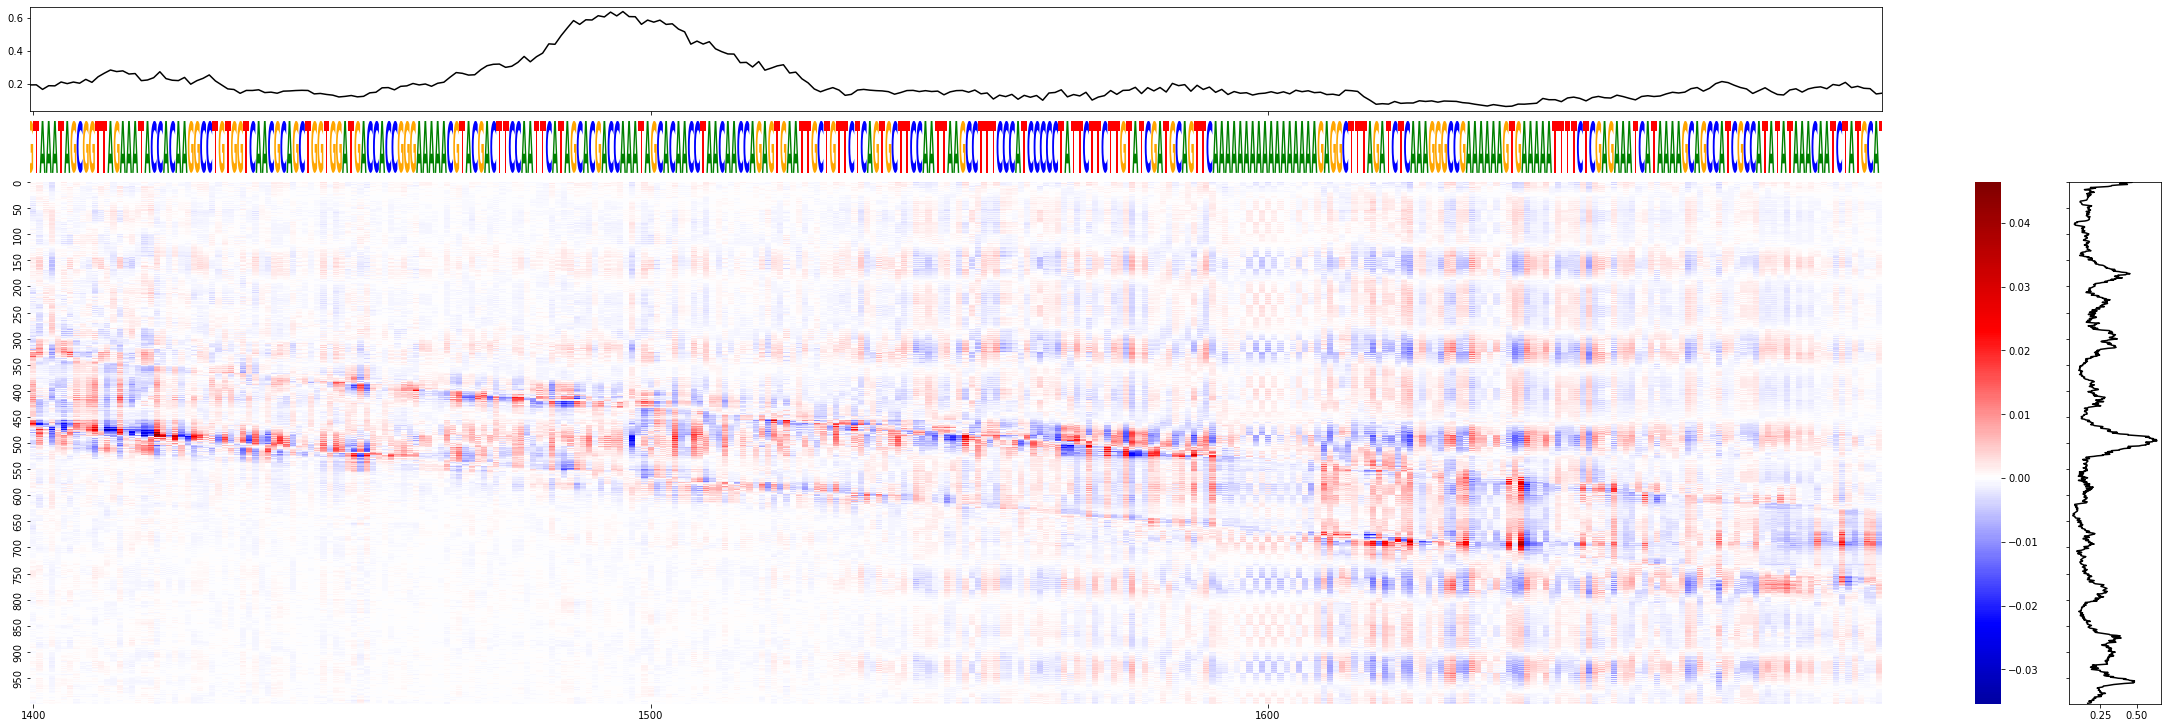

In [37]:
aligned_grads_seq = pd.DataFrame(
    0.,
    index = np.arange(n_seqs),
    columns = np.arange(2000+n_seqs))
for i in range(len(grads_seq)):
    aligned_grads_seq.iloc[i, i:2001+i] = grads_seq[i]

plot_start = mid_idx + 900
plot_stop = mid_idx + 1201
fig, axes = plt.subplots(3, 2, figsize=(30, 10), sharex='col', sharey='row', layout='constrained',
                         gridspec_kw={'width_ratios': [20, 1],
                                      'height_ratios': [2, 1, 10]})
fig.set_facecolor('w')
axes[0, 0].plot(preds[plot_start:plot_stop], color='k', label='predictions')
lm.Logo(pd.DataFrame(one_hot[plot_start:plot_stop], columns=list('ATCG')), ax=axes[1, 0])
axes[1, 0].set_axis_off()
sns.heatmap(aligned_grads_seq.iloc[:, plot_start:plot_stop-1], cmap='seismic', center=0, ax=axes[2, 0],# cbar_ax=axes[0, 1],
            xticklabels=100, yticklabels=50)
axes[2, 1].plot(Y, np.arange(n_seqs), color='k', label='predictions')
axes[0, 1].remove()
axes[1, 1].remove()
plt.show()
plt.close()

In [38]:
np.quantile(Y, [0.4, 0.5, 0.6]), np.quantile(preds_nuc['chr16'], [0.4, 0.5, 0.6])

(array([0.16661229, 0.18374011, 0.20892507]),
 array([0.15912554, 0.17530998, 0.19330625]))

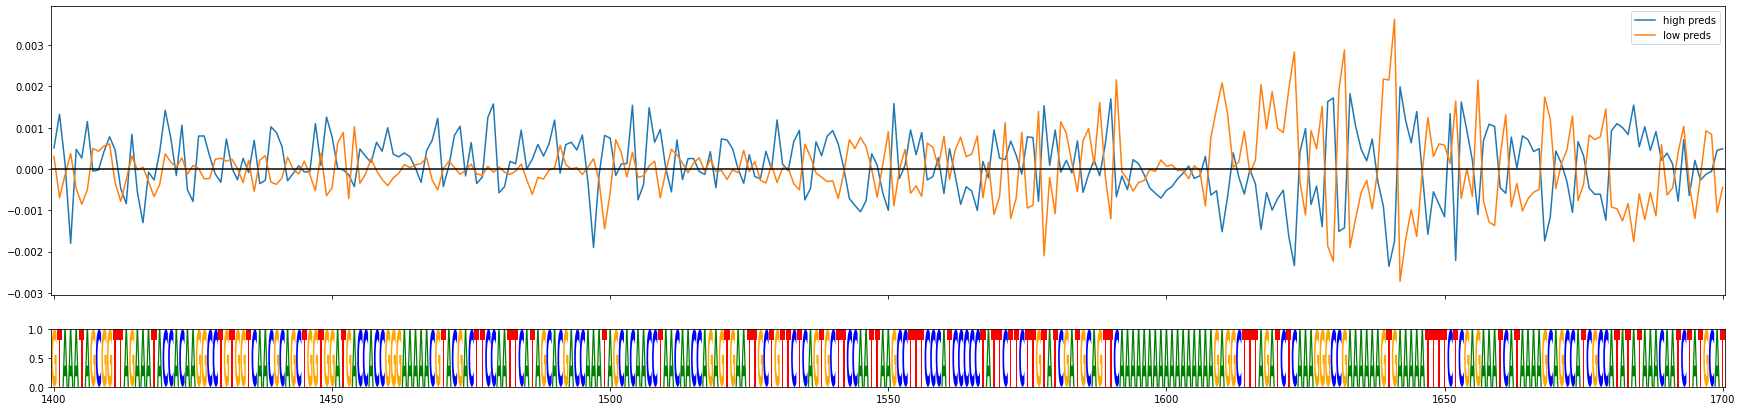

In [39]:
plot_start = mid_idx + 900
plot_stop = mid_idx + 1201
fig, axes = plt.subplots(2, 1, figsize=(30, 7), sharex='col', facecolor='w',
                         gridspec_kw={'height_ratios': [5, 1]})
aligned_grads_seq[high].mean(axis=0).loc[plot_start:plot_stop-1].plot(ax=axes[0], label='high preds')
aligned_grads_seq[low].mean(axis=0).loc[plot_start:plot_stop-1].plot(ax=axes[0], label='low preds')
axes[0].axhline(y=0, color='k')
axes[0].legend()
lm.Logo(pd.DataFrame(one_hot, columns=list('ATCG')).loc[plot_start:plot_stop-1], ax=axes[1])

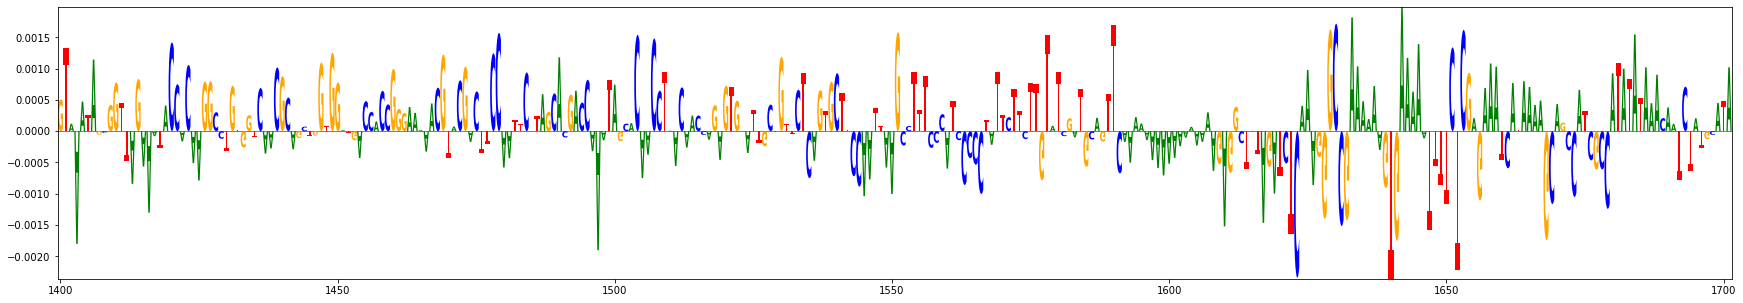

In [40]:
plot_start = mid_idx + 900
plot_stop = mid_idx + 1201
df_high_preds = pd.DataFrame(one_hot, columns=list('ATCG')).multiply(
    aligned_grads_seq[high].mean(axis=0),
    axis=0)
fig, ax = plt.subplots(1, 1, figsize=(30, 5), facecolor='w')
lm.Logo(df_high_preds.loc[plot_start:plot_stop], ax=ax)


Modisco visulatisation

In [10]:
def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(f'{pre}└── {key}')
                h5_tree(val, pre+'    ')
            else:
                print(f'{pre}└── {key} {val.shape}')
        else:
            if type(val) == h5py._hl.group.Group:
                print(f'{pre}├── {key}')
                h5_tree(val, pre+'│   ')
            else:
                print(f'{pre}├── {key} {val.shape}')

In [223]:
with h5py.File(Path(data_dir, species, 'results', 'models_etienne', 'modisco', f'modisco_results_test6_low.h5'), 'r') as f:
    h5_tree(f['pos_patterns']['pattern_0'])
# subpattern_0 contains same info as pattern_{idx}

├── contrib_scores (30, 4)
├── hypothetical_contribs (30, 4)
├── seqlets
│   ├── contrib_scores (29, 30, 4)
│   ├── end (29,)
│   ├── example_idx (29,)
│   ├── hypothetical_contribs (29, 30, 4)
│   ├── is_revcomp (29,)
│   ├── n_seqlets (1,)
│   ├── sequence (29, 30, 4)
│   └── start (29,)
├── sequence (30, 4)
└── subpattern_0
    ├── contrib_scores (30, 4)
    ├── hypothetical_contribs (30, 4)
    ├── seqlets
    │   ├── contrib_scores (29, 30, 4)
    │   ├── end (29,)
    │   ├── example_idx (29,)
    │   ├── hypothetical_contribs (29, 30, 4)
    │   ├── is_revcomp (29,)
    │   ├── n_seqlets (1,)
    │   ├── sequence (29, 30, 4)
    │   └── start (29,)
    └── sequence (30, 4)


In [21]:
allseqs = []
for test_idx in range(7, 9):
    with h5py.File(Path(data_dir, species, 'results', 'models_etienne', 'modisco', f'modisco_results_test{test_idx}_max_sum.h5'), 'r') as f:
        print('test', test_idx, list(f.keys()))
        for signkey in ['pos_patterns', 'neg_patterns']:
            if signkey in f.keys():
                # Show important file info
                print(f'{signkey}: {len(f[signkey])}', [v['seqlets']['n_seqlets'][0] for v in f[signkey].values()])
                # Check equivalences in file
                for patkey, pat in f[signkey].items():
                    # if test_idx <= 8:
                    #     assert np.allclose(pat['contrib_scores'][:], pat['hypothetical_contribs'][:])
                    if list(pat.keys())[-1] == 'subpattern_0':
                        assert np.allclose(pat['sequence'][:], pat['subpattern_0']['sequence'][:])
                        assert np.allclose(pat['contrib_scores'][:], pat['subpattern_0']['contrib_scores'][:])
                        assert np.allclose(pat['hypothetical_contribs'][:], pat['subpattern_0']['hypothetical_contribs'][:])
                        for seqkey in pat['subpattern_0']['seqlets'].keys():
                            assert np.allclose(pat['seqlets'][seqkey][:], pat['subpattern_0']['seqlets'][seqkey][:])
                    else:
                        n_subpatterns = int(list(pat.keys())[-1][11:]) + 1
                        print(f'\t{patkey} subpatterns: {n_subpatterns}', [v['seqlets']['n_seqlets'][0] for v in list(pat.values())[-n_subpatterns:]])
                # Save sequences by file and sign
                seqs = {}
                for patkey in f[signkey].keys():
                    seqs[patkey] = pd.DataFrame(f[signkey][patkey]['sequence'][:], columns=list('ATCG'))
                seqs = dict(sorted(seqs.items(), key=lambda x: int(x[0][8:])))
                if len(seqs) != 0:
                    allseqs.append(seqs)

test 7 ['neg_patterns', 'pos_patterns']
pos_patterns: 10 [46, 41, 33, 28, 26, 26, 24, 24, 24, 22]
neg_patterns: 5 [51, 41, 37, 26, 24]
test 8 ['pos_patterns']
pos_patterns: 12 [55, 55, 24, 24, 54, 54, 54, 53, 50, 50, 45, 28]
	pattern_0 subpatterns: 4 [18, 15, 11, 11]
	pattern_1 subpatterns: 3 [19, 19, 17]
	pattern_2 subpatterns: 3 [23, 20, 11]
	pattern_3 subpatterns: 3 [20, 19, 15]
	pattern_4 subpatterns: 2 [29, 25]
	pattern_5 subpatterns: 3 [24, 19, 10]


In [22]:
(
    pos7,
    neg7,
    pos8,
    # neg8,
) = allseqs
titles = np.array(['saliency pos', 'saliency neg', 'DeepLIFT pos', 'DeepLIFT neg'])#, 'DeepLIFT hyp pos', 'DeepLIFT hyp neg'])
titles = titles[[0, 1, 2]]

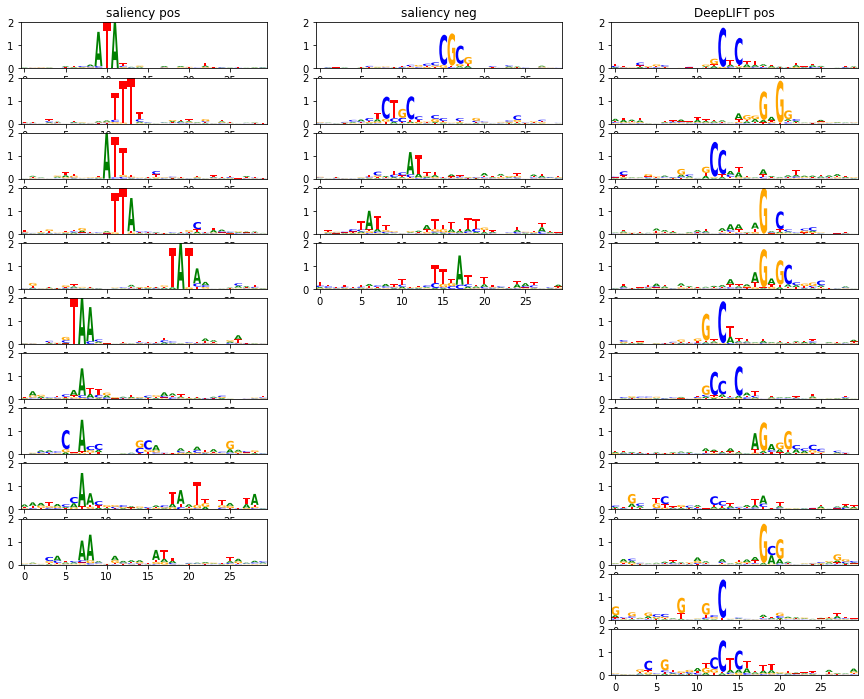

In [23]:
max_len = max((len(v) for v in allseqs))
fig, axes = plt.subplots(max_len, len(allseqs), figsize=(5*len(allseqs), max_len))
for j, seqs in enumerate(allseqs):
    axes[0, j].set_title(titles[j])
    for i, (patkey, seq) in enumerate(seqs.items()):
        if i >= max_len:
            print(f'Exceeding max_len in column {j}')
            break
        pwm = seq * np.log2(seq)
        pwm.fillna(0, inplace=True)
        lm.Logo(seq.multiply(2 + pwm.sum(axis=1), axis=0), ax=axes[i, j])
        axes[i, j].set_ylim((0, 2))
    for k in range(i+1, max_len):
        axes[k, j].set_axis_off()

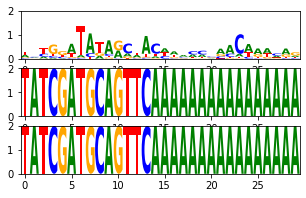

In [162]:
fig, axes = plt.subplots(len(neg4), 1, figsize=(5, len(neg4)))
for i, (patkey, seq) in enumerate(neg4.items()):
    pwm = seq * np.log2(seq)
    pwm.fillna(0, inplace=True)
    lm.Logo(seq.multiply(2 + pwm.sum(axis=1), axis=0), ax=axes[i])
    axes[i].set_ylim((0, 2))